## Load Data and Prepare Features
Load train and validation splits, extract features and targets, and handle missing values using median.


In [37]:
# Prepare features and targets for training
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd

df_train = pd.read_csv('data/splits/train.csv')
df_val = pd.read_csv('data/splits/val.csv')

# Prepare features (X): day_of_month, is_weekend, is_public_holiday, days_from_summer_start
feature_cols = ['day_of_month', 'is_weekend', 'is_public_holiday', 'days_from_summer_start']
X_train = df_train[feature_cols].values
X_val = df_val[feature_cols].values

# Prepare targets (y): all 60 days-to-departure columns
target_cols = [col for col in df_train.columns if 'days to departure' in col]
y_train = df_train[target_cols].values
y_val = df_val[target_cols].values

# Handle missing values in targets (fill with median of each column)
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
y_train = imputer.fit_transform(y_train)
y_val = imputer.transform(y_val)

print(f"Training features shape: {X_train.shape}")
print(f"Training targets shape: {y_train.shape}")
print(f"Validation features shape: {X_val.shape}")
print(f"Validation targets shape: {y_val.shape}")

Training features shape: (64, 4)
Training targets shape: (64, 60)
Validation features shape: (14, 4)
Validation targets shape: (14, 60)


## Train Model
Train a XGBoost regression model to predict flight prices for all 60 days-to-departure horizons.


In [38]:
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
# Train multi-output regression model using XGBoost
# Use MultiOutputRegressor to handle multiple target outputs
base_model = XGBRegressor(
    max_depth=100,
    learning_rate=0.001,
    n_estimators=600,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

model = MultiOutputRegressor(base_model)
print("Training model...")
model.fit(X_train, y_train)
print("Training completed!")

y_val_pred = model.predict(X_val)
print("Predictions completed!")


Training model...
Training completed!
Predictions completed!


## Evaluate and Visualize Results
Calculate MAE metrics and create visualizations comparing predictions to ground truth across different days-to-departures.



PREDICTION COMPARISON SUMMARY

Validation Results:
Overall MAE: 65.91

Total predictions: 840
Number of samples: 14
Number of outputs per sample: 60

Comparison DataFrame (first 20 rows):
    sample_idx  days_to_departure      actual   predicted  absolute_error
0            0                  1  435.381250  548.501526      113.120276
1            0                  2  482.261290  535.318237       53.056947
2            0                  3  529.019355  541.994873       12.975518
3            0                  4  355.332143  545.896484      190.564342
4            0                  5  391.777419  555.091370      163.313950
..         ...                ...         ...         ...             ...
95           1                 36  516.318400  532.363220       16.044820
96           1                 37  581.525000  526.507019       55.017981
97           1                 38  529.680417  519.001831       10.678586
98           1                 39  517.160400  511.821228        5.3391

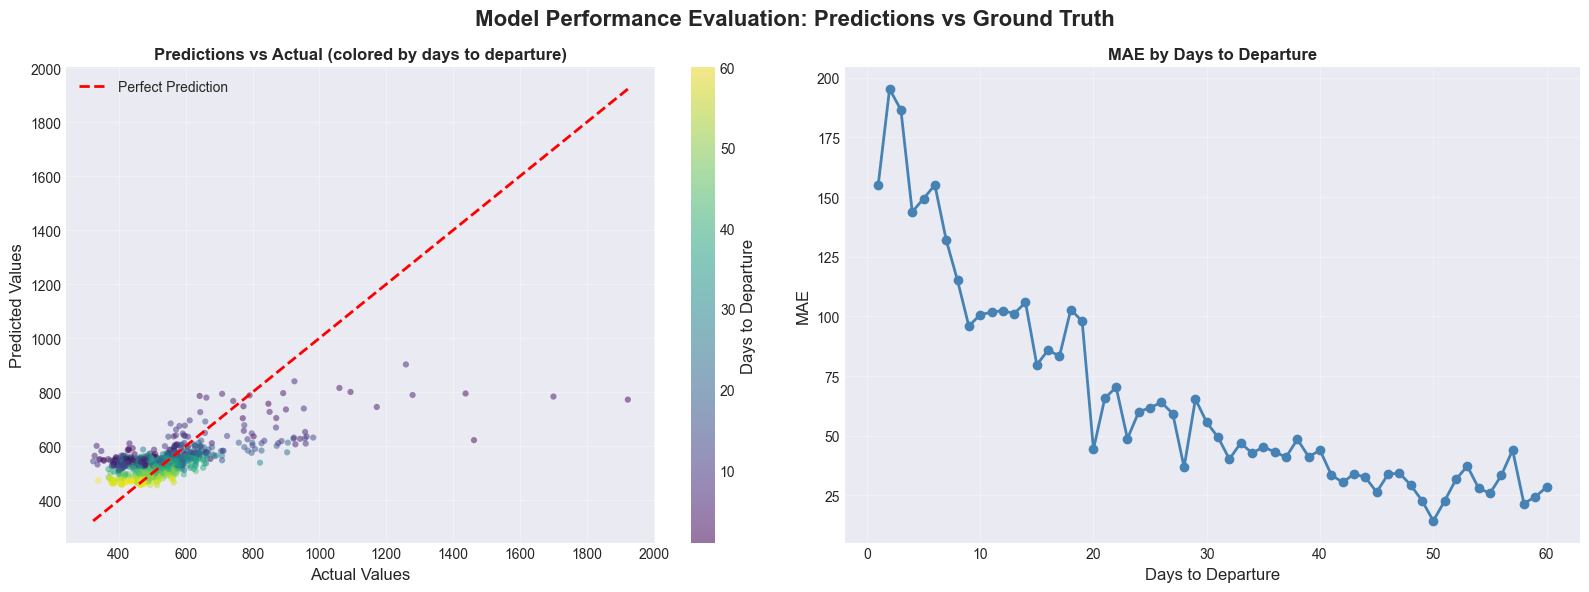

In [39]:
# ============================================================================
# Model Evaluation Visualizations
# ============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better-looking plots
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except OSError:
    try:
        plt.style.use('seaborn-darkgrid')
    except OSError:
        plt.style.use('ggplot')
sns.set_palette("husl")

# Flatten predictions and actuals for comparison DataFrame
n_samples, n_outputs = y_val.shape
comparison_data = []

for sample_idx in range(n_samples):
    for output_idx in range(n_outputs):
        actual = y_val[sample_idx, output_idx]
        predicted = y_val_pred[sample_idx, output_idx]
        abs_error = abs(actual - predicted)
        pct_error = (abs_error / actual * 100) if actual != 0 else np.nan
        
        # Extract days to departure from column name
        days_to_departure = int(target_cols[output_idx].split()[0])
        
        comparison_data.append({
            'sample_idx': sample_idx,
            'days_to_departure': days_to_departure,
            'actual': actual,
            'predicted': predicted,
            'absolute_error': abs_error,
        })

comparison_df = pd.DataFrame(comparison_data)

# Display comparison DataFrame summary
print("\n" + "="*80)
print("PREDICTION COMPARISON SUMMARY")
print("="*80)

mae_per_output = [mean_absolute_error(y_val[:, i], y_val_pred[:, i]) for i in range(y_val.shape[1])]
overall_mae = mean_absolute_error(y_val, y_val_pred)

print(f"\nValidation Results:")
print(f"Overall MAE: {overall_mae:.2f}")

print(f"\nTotal predictions: {len(comparison_df)}")
print(f"Number of samples: {n_samples}")
print(f"Number of outputs per sample: {n_outputs}")
print(f"\nComparison DataFrame (first 20 rows):")
print(comparison_df.head(100))

# ============================================================================
# Visualizations: Predictions vs Actual and MAE by Days to Departure
# ============================================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Model Performance Evaluation: Predictions vs Ground Truth', fontsize=16, fontweight='bold')

# Plot 1: Scatter plot - Predictions vs Actual
ax1 = axes[0]
scatter = ax1.scatter(comparison_df['actual'], comparison_df['predicted'], 
                     alpha=0.5, s=20, c=comparison_df['days_to_departure'], 
                     cmap='viridis', edgecolors='none')
min_val = min(comparison_df['actual'].min(), comparison_df['predicted'].min())
max_val = max(comparison_df['actual'].max(), comparison_df['predicted'].max())
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Values', fontsize=12)
ax1.set_ylabel('Predicted Values', fontsize=12)
ax1.set_title('Predictions vs Actual (colored by days to departure)', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax1, label='Days to Departure')

# Plot 2: MAE by Days to Departure
ax2 = axes[1]
days_list = [int(col.split()[0]) for col in target_cols]
ax2.plot(days_list, mae_per_output, marker='o', linewidth=2, markersize=6, color='steelblue')
ax2.set_xlabel('Days to Departure', fontsize=12)
ax2.set_ylabel('MAE', fontsize=12)
ax2.set_title('MAE by Days to Departure', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xticks(range(0, 61, 10))

plt.tight_layout()
plt.show()

In [ ]:
def run_version(version):
    base_path = f"data/splits_{version}"
    
    df_train = pd.read_csv(f"{base_path}/train.csv")
    df_val   = pd.read_csv(f"{base_path}/val.csv")

    target_cols = [c for c in df_train.columns if "days to departure" in c]

    feature_candidates = [
        "day_of_month","is_weekend","is_public_holiday","days_from_summer_start",
        "flight_day_of_week","flight_month",
        "week_of_year","season",
        "mean_price","slope_1","slope_2"
    ]
    feature_cols = [c for c in feature_candidates if c in df_train.columns]

    X_train = df_train[feature_cols].values
    X_val   = df_val[feature_cols].values
    y_train = df_train[target_cols].values
    y_val   = df_val[target_cols].values

    # median fill
    imputer = SimpleImputer(strategy="median")
    y_train = imputer.fit_transform(y_train)
    y_val   = imputer.transform(y_val)

    # model
    model = MultiOutputRegressor(
        XGBRegressor(
            max_depth=100,
            learning_rate=0.001,
            n_estimators=600,
            subsample=0.8,
            colsample_bytree=0.8,
            objective="reg:squarederror",
            random_state=42,
        )
    )

    print(f"\nTraining model for {version}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    if version == "v5":
        y_val_eval = np.expm1(y_val)
        y_pred_eval = np.expm1(y_pred)

        mae = mean_absolute_error(y_val_eval, y_pred_eval)

    else:
        mae = mean_absolute_error(y_val, y_pred)

    print(f"{version} MAE = {mae:.2f}")
    return mae, y_pred, y_val, target_cols


In [55]:
mae_results = {}

for version in ["v3", "v4", "v5", "v6"]:
    mae, _, _, _ = run_version(version)
    mae_results[version] = mae


Training model for v3...
v3 MAE = 71.90

Training model for v4...
v4 MAE = 69.46

Training model for v5...
v5 detected: converting log-values back using expm1()
v5 MAE = 68.51

Training model for v6...
v6 MAE = 63.00


In [56]:
feature_cols_v2 = ["day_of_month","is_weekend","is_public_holiday","days_from_summer_start"]

In [57]:
df_train_v7 = df_train.copy()
df_val_v7   = df_val.copy()

df_train_v7["flight_day_of_week"] = (df_train_v7.index % 7) / 6
df_val_v7["flight_day_of_week"]   = (df_val_v7.index % 7) / 6
df_train_v7["flight_month"] = (df_train_v7.index % 30) / 30
df_val_v7["flight_month"]   = (df_val_v7.index % 30) / 30

feature_cols_v7 = feature_cols_v2 + ["flight_day_of_week","flight_month"]

X_train_v7 = df_train_v7[feature_cols_v7].values
X_val_v7   = df_val_v7[feature_cols_v7].values

# FIXED LINES
y_train_v7 = y_train.copy()
y_val_v7   = y_val.copy()

def smooth(arr, window=5):
    s = pd.Series(arr)
    return s.rolling(window=window, min_periods=1, center=True).mean().values

y_train_v7 = np.apply_along_axis(smooth, 1, y_train_v7)
y_val_v7   = np.apply_along_axis(smooth, 1, y_val_v7)

caps = np.percentile(y_train_v7, 98, axis=0)
y_train_v7 = np.minimum(y_train_v7, caps)

model_v7 = MultiOutputRegressor(
    XGBRegressor(
        max_depth=100,
        learning_rate=0.001,
        n_estimators=600,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=42
    )
)

print("\nTraining V7 model...")
model_v7.fit(X_train_v7, y_train_v7)
y_pred_v7 = model_v7.predict(X_val_v7)

overall_mae_v7 = mean_absolute_error(y_val_v7, y_pred_v7)
print("\nV7 FINAL MAE:", overall_mae_v7)



Training V7 model...

V7 FINAL MAE: 59.451865504938056


In [58]:
print("\n\n====== MAE SUMMARY ======")

# v2 baseline
v2_mae = mean_absolute_error(y_val, model.predict(X_val))
print("v2:", v2_mae)

# other versions
print("v3:", mae_results["v3"])
print("v4:", mae_results["v4"])
print("v5:", mae_results["v5"])
print("v6:", mae_results["v6"])
print("v7:", overall_mae_v7)



====== MAE SUMMARY ======
v2: 65.91265927005756
v3: 71.90260837603059
v4: 69.45778361969933
v5: 68.51022823179905
v6: 63.00322251393554
v7: 59.451865504938056


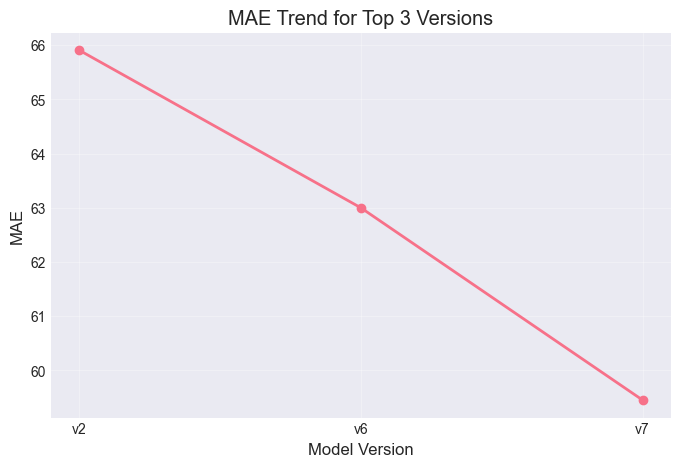

In [60]:
versions = ["v2", "v6", "v7"]
mae_values = [65.91, 63.00, 59.45]

plt.figure(figsize=(8,5))
plt.plot(versions, mae_values, marker='o', linewidth=2)
plt.title("MAE Trend for Top 3 Versions")
plt.ylabel("MAE")
plt.xlabel("Model Version")
plt.grid(True, alpha=0.3)
plt.show()